In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import sys
sys.path.insert(1, '/kaggle/input/quadrule')

from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time
import os


2023-09-27 20:59:10.903539: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 20:59:10.905026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 20:59:10.940225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 20:59:10.940770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 20:59:11.659045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
class VPINN(tf.keras.Model):

    def __init__(self, pb, params,seed,NN):

        super().__init__()

        # accept parameters
        self.pb = pb
        self.params = params
        self.SEED=seed

        # generate all precomp stuff
        self.generate_boundary_points()
        self.generate_inner_points()
        self.generate_quadrature_points()
        self.construct_RHS()

        # add the neural network to the class if given at initialisation
        if NN:
            self.set_NN(NN)
        else: 
            self.NN=self.initialize_NN()
            self.vars = self.NN.trainable_variables
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.params['LR'])

    def set_NN(self, NN, LR):
        np.random.seed(self.SEED)
        tf.random.set_seed(self.SEED)
        # initialise the NN
        self.NN = NN

        # take trainable vars
        self.vars = self.NN.trainable_variables

        # set optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    def initialize_NN(self):

        NN = tf.keras.Sequential()
        NN.add(tf.keras.layers.InputLayer(self.params['NN_struct'][0],dtype=tf.float64))
        # NN.add(tf.keras.layers.Lambda(lambda x: 2. * (x + 1) / (2) - 1.))

        for width in self.params['NN_struct'][1:-1]:
            NN.add(tf.keras.layers.Dense(width,
                                            activation=tf.math.sin,
                                            use_bias=True,
                                            kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED),
                                            bias_initializer='zeros',dtype=tf.float64))
        NN.add(tf.keras.layers.Dense(self.params['NN_struct'][-1], activation='linear',dtype=tf.float64,kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED)))

        return NN


    def eval_NN(self, x):
        x = tf.convert_to_tensor(x, dtype=tf.float64)        

        with tf.GradientTape() as second_order:
            second_order.watch(x)
            with tf.GradientTape() as first_order:
                first_order.watch(x)
                u = self.NN(x)
            d1xu = first_order.gradient(u, x)
        d2xu = second_order.gradient(d1xu, x)

        del first_order
        del second_order

        return u, d1xu, d2xu

    def boundary_loss(self):
    ## NOTE:impose boundary or same structure for ICs
        u_bound_NN = self.eval_NN(self.boundary_points)[0]
        return tf.reduce_mean(tf.square(u_bound_NN - self.boundary_sol))

    def variational_loss(self):
        #TODO: general organisation
        varloss_total = 0.0
        N = self.params['n_elements']
        for el in range(N):
                
            n_test = self.params['n_test'][el]

            F_ext_element = self.F_ext_total[el]
            jacobian = self.J[el]
            x_quad_element = self.x_quad_total[el]
            v_quad_element = self.v_quad_total[el]
            dv_quad_element = self.dv_quad_total[el]
            dv_boundary_element = self.dv_boundary_total[el]
            d2v_quad_element = self.d2v_quad_total[el]


            u_NN_quad_el, d1xu_NN_quad_el, d2xu_NN_quad_el = self.eval_NN(x_quad_element)
            # dv_boundary_element, _ = self.pb.dtest_func(n_test, np.array([-1, 1]))

            if self.params['var_form'] == 0:
                u_NN_el = tf.stack([-jacobian*tf.reduce_sum(self.w_quad*d2xu_NN_quad_el*v_quad_element[i]) \
                                    for i in range(n_test)])

            elif self.params['var_form'] == 1:
                u_NN_el = tf.stack([tf.reduce_sum(self.w_quad*d1xu_NN_quad_el*dv_quad_element[i]) \
                                    for i in range(n_test)])
                

            elif self.params['var_form'] == 2:
                u_NN_bound_el, _, _  = self.eval_NN(np.array([x_quad_element[0], x_quad_element[-1]]))
                u_NN_el = tf.stack([-1/jacobian*tf.reduce_sum(self.w_quad*u_NN_quad_el*d2v_quad_element[i]) \
                                    +1/jacobian*tf.reduce_sum(u_NN_bound_el*np.array([-dv_boundary_element[i][0], dv_boundary_element[i][-1]]))  \
                                    for i in range(n_test)])
            

            res_NN_element = u_NN_el - F_ext_element
            loss_element = tf.reduce_mean(tf.square(res_NN_element))
            varloss_total = varloss_total + loss_element


        return varloss_total

    @tf.function
    def loss_total(self):
        loss_0 = 0.0
        loss_b = self.boundary_loss()
        loss_v = self.variational_loss()
        loss_tot = loss_0 + loss_b + loss_v
        return loss_tot, loss_b, loss_v

    def loss_gradient(self):
        with tf.GradientTape(persistent=True) as loss_grad:
            #TODO: why is this commented?
            # loss_grad.watch(self.vars)
            loss_tot, loss_b, loss_v = self.loss_total()
        gradient = loss_grad.gradient(loss_tot, self.vars)
        return loss_tot, loss_b, loss_v, gradient

    @tf.function
    def gradient_descent(self):
        loss_tot, loss_b, loss_v, gradient = self.loss_gradient()
        self.optimizer.apply_gradients(zip(gradient, self.vars))
        return loss_tot, loss_b, loss_v

    def train(self, opt_iter):

        history = []

        start_time = time.time()
        for i in range(opt_iter):

            loss_tot, loss_b, loss_v = self.gradient_descent()

            if i % 10 == 0:
                elapsed = time.time() - start_time
                print(f'Iteration: {i}', f'loss: {loss_tot.numpy():0.6f}', f'time: {elapsed}')
                history.append([i, loss_tot, loss_b, loss_v])
                start_time = time.time()

        history = np.array(history)
        self.iterations = history[:,0]
        self.loss_tot = history[:,1]
        self.loss_b = history[:,2]
        self.loss_v = history[:,3]

        return self.loss_tot

    def get_domain_info(self):

        a = self.params['domain'][0]
        b = self.params['domain'][1]

        scale = b - a
        mid = (a + b)*0.5

        return a, b, scale, mid

    def generate_boundary_points(self):
        # Boundary points
        a, b, scale, mid = self.get_domain_info()

        self.boundary_points = np.asarray([a,b], dtype=np.float64)[:,None]
        self.boundary_sol = self.pb.u_exact(self.boundary_points)


    def generate_inner_points(self):
        _, _, scale, mid = self.get_domain_info()

        self.X_f_train = np.array(scale*(lhs(1, self.params['n_bound']) - 0.5) + mid).flatten()
        self.f_train = np.asarray(self.pb.f_exact(self.X_f_train))
        # self.f_train = ff[:, None]

    def generate_quadrature_points(self):
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(self.params['n_quad'], 0, 0)



    def construct_RHS(self):
        #TODO: check are the convert to tensors are needed
        N = self.params['n_elements']
        lower_bound, upper_bound, _, _ = self.get_domain_info()
        dx = (upper_bound - lower_bound)/N
        self.grid_x = np.asarray([lower_bound + i*dx for i in range(N+1)])
        n_test_funcs = self.params['n_test']

        self.U_ext_total = []
        self.F_ext_total = []
        self.J = []
        self.x_quad_total = []
        self.v_quad_total = []
        self.dv_quad_total = []
        self.dv_boundary_total = []
        self.d2v_quad_total = []

        for el_x in range(N):
            Ntest_element = n_test_funcs[el_x]

            a = self.grid_x[el_x]
            b = self.grid_x[el_x+1]

            jacobian = (b - a)/2
            x_quad_element = a + jacobian*(self.x_quad+1)

            v_quad_element = self.pb.test_func(Ntest_element, self.x_quad)        
            dv_quad_element, d2v_quad_element = self.pb.dtest_func(Ntest_element, self.x_quad)
            dv_boundary_element, _ = self.pb.dtest_func(Ntest_element, np.array([a, b]))

            u_quad_element = self.pb.u_exact(x_quad_element)
            f_quad_element = self.pb.f_exact(x_quad_element)

            U_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*u_quad_element)
                for r in range(Ntest_element)])

            F_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*f_quad_element)
                for r in range(Ntest_element)])


            self.U_ext_total.append(U_ext_element)
            self.F_ext_total.append(F_ext_element)
            self.J.append(jacobian)
            self.x_quad_total.append(x_quad_element)
            self.v_quad_total.append(v_quad_element)
            self.dv_quad_total.append(dv_quad_element)
            self.dv_boundary_total.append(dv_boundary_element)
            self.d2v_quad_total.append(d2v_quad_element)

            
        self.F_ext_total = tf.convert_to_tensor(self.F_ext_total, tf.float64)

    def generate_test_points(self):
        lower_bound, upper_bound, _, _ = self.get_domain_info()

        delta_test = self.params['delta_test']
        x_test = np.arange(lower_bound, upper_bound + delta_test, delta_test)
        data_temp = np.asarray([[x_test[i], self.pb.u_exact(x_test[i])]
                                 for i in range(len(x_test))])
    
        x_test = data_temp.flatten()[0::2]
        exact = data_temp.flatten()[1::2]
        return x_test[:, None], exact[:, None], len(x_test)
    

    def plot_loss_history(self, PLOT='SHOW'):

        font = 24
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()
        
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.plot(self.iterations, self.loss_b,'blue',label="boundary_loss")
        plt.plot(self.iterations, self.loss_v, 'violet',label="variational_loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('VPINN_loss_history.pdf')
        else:
            plt.show()
        

    def plot_predict(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()
        prediction = self.eval_NN(x)[0]
        
        pnt_skip = 25
        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)

        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('$u$', fontsize = 24)
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, sol, linewidth=1, color='r', label=''.join(['$exact$']))
        plt.plot(x, prediction, 'k*', label='$VPINN$')
        plt.tick_params( labelsize = 20)
        legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Exact.png')
        else:
            plt.show()
        
        
    def plot_pointwise_error(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()

        prediction = self.eval_NN(x)[0]

        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)
        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('point-wise error', fontsize = 24)
        plt.yscale('log')
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, abs(sol - prediction), 'k')
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Pointwise_Error.png')
        else:
            plt.show()

In [3]:
class PROBDEF:

    def __init__(self, omega: tuple, r: int):
        self.omega = omega
        self.r = r

    def u_exact(self, x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r*x)
        return utemp

    def f_exact(self, x):
        A =  0.1*(self.omega**2)*np.sin(self.omega*x)
        B = (2*self.r**2)*(np.tanh(self.r*x))
        B /= (np.cosh(self.r*x)); B /= (np.cosh(self.r*x))
        return A + B

    @staticmethod
    def test_func_core(n, x):
        test = Jacobi(n+1, 0, 0, x) - Jacobi(n-1, 0, 0, x)
        return test

    def test_func(self, n_test, x):
        test_total = [self.test_func_core(n, x) for n in range(1, n_test+1)]
        return np.asarray(test_total)

    def dtest_func(self, n_test, x):
        n = 1
        d1test_total = [((n+2)/2)*Jacobi(n, 1, 1, x)]
        d2test_total = [((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)]
        for n in range(2, n_test+1):
            if n == 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n > 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x) - ((n)*(n+1)/(2*2))*Jacobi(n-3, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            else:
                raise ValueError("Please check the value for 'n_test'")
        return np.asarray(d1test_total), np.asarray(d2test_total)
    
    
'''
Hyper-parameters: 
    scheme     = is either 'PINNs' or 'VPINNs'
    Net_layer  = the structure of fully connected network
    var_form   = the form of the variational formulation used in VPINNs
                    0, 1, 2: no, once, twice integration-by-parts
    N_el_x, N_el_y     = number of elements in x and y direction
    N_test_x, N_test_y = number of test functions in x and y direction
    N_quad     = number of quadrature points in each direction in each element
    N_bound    = number of boundary points in the boundary loss
    N_residual = number of residual points in PINNs
'''

"\nHyper-parameters: \n    scheme     = is either 'PINNs' or 'VPINNs'\n    Net_layer  = the structure of fully connected network\n    var_form   = the form of the variational formulation used in VPINNs\n                    0, 1, 2: no, once, twice integration-by-parts\n    N_el_x, N_el_y     = number of elements in x and y direction\n    N_test_x, N_test_y = number of test functions in x and y direction\n    N_quad     = number of quadrature points in each direction in each element\n    N_bound    = number of boundary points in the boundary loss\n    N_residual = number of residual points in PINNs\n"

In [4]:
pb = PROBDEF((8*np.pi), 80)
N_tests = 20
N_elements = 5
params = {'scheme': 'VPINNs',
            'NN_struct': [1] + [20] * 4 + [1],
            'var_form': 1,
            'n_elements': N_elements,
            'n_test': N_elements*[N_tests],
            'n_quad': 100,
            'n_bound': 50,
            'n_residual': 100,
            'domain': (-1, 1),
            'Opt_Niter': 2500 + 1,
            'delta_test': 0.01,
            'LR': 0.001}
print(params)

{'scheme': 'VPINNs', 'NN_struct': [1, 20, 20, 20, 20, 1], 'var_form': 1, 'n_elements': 5, 'n_test': [20, 20, 20, 20, 20], 'n_quad': 100, 'n_bound': 50, 'n_residual': 100, 'domain': (-1, 1), 'Opt_Niter': 2501, 'delta_test': 0.01, 'LR': 0.001}


/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


Number of elements :  5


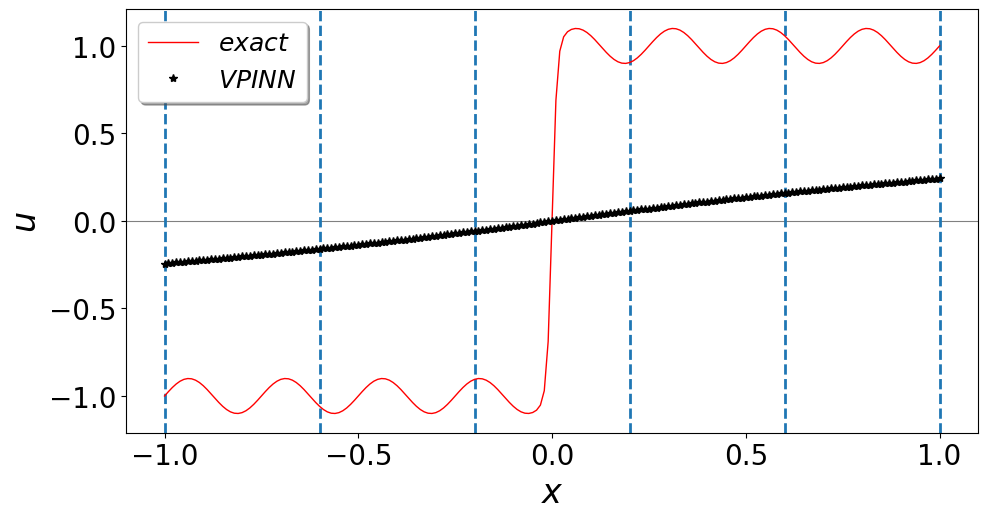

Iteration: 0 loss: 866.576966 time: 4.663073301315308
Iteration: 10 loss: 865.882177 time: 0.013179779052734375
Iteration: 20 loss: 865.731461 time: 0.012134313583374023
Iteration: 30 loss: 865.147492 time: 0.00976252555847168
Iteration: 40 loss: 863.436228 time: 0.012825965881347656
Iteration: 50 loss: 857.608919 time: 0.01245570182800293
Iteration: 60 loss: 840.086208 time: 0.011554956436157227
Iteration: 70 loss: 806.256685 time: 0.010098934173583984
Iteration: 80 loss: 759.249139 time: 0.012164592742919922
Iteration: 90 loss: 665.493932 time: 0.01188039779663086
Iteration: 100 loss: 543.058533 time: 0.00969696044921875
Iteration: 110 loss: 479.833331 time: 0.012172698974609375
Iteration: 120 loss: 409.340307 time: 0.012419462203979492
Iteration: 130 loss: 336.424012 time: 0.010166406631469727
Iteration: 140 loss: 222.202057 time: 0.011913299560546875
Iteration: 150 loss: 153.448523 time: 0.012106895446777344
Iteration: 160 loss: 130.576211 time: 0.010068893432617188
Iteration: 170 

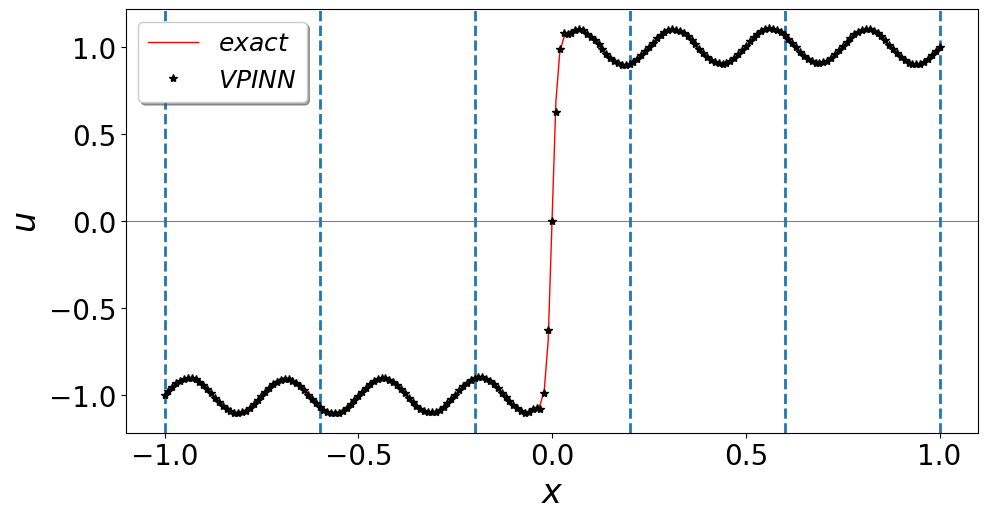

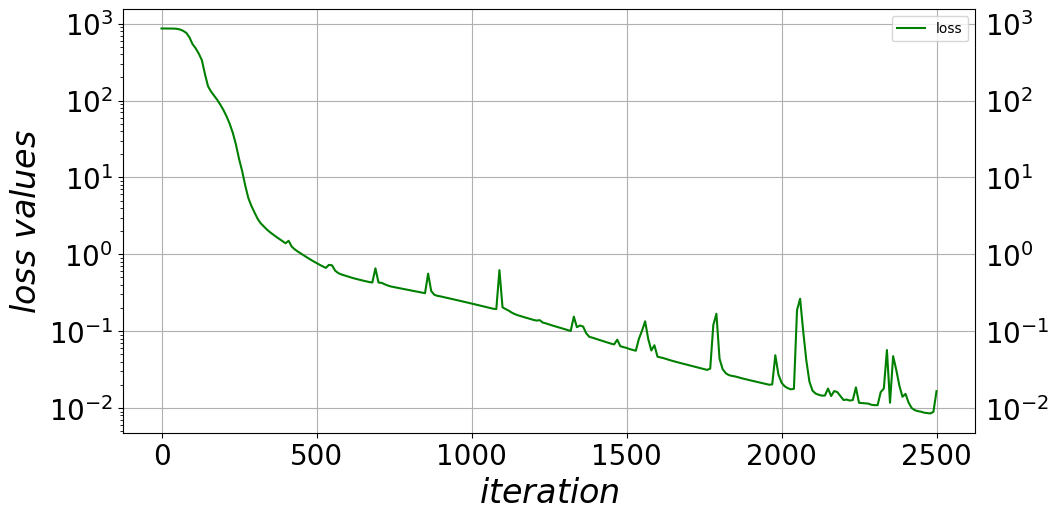

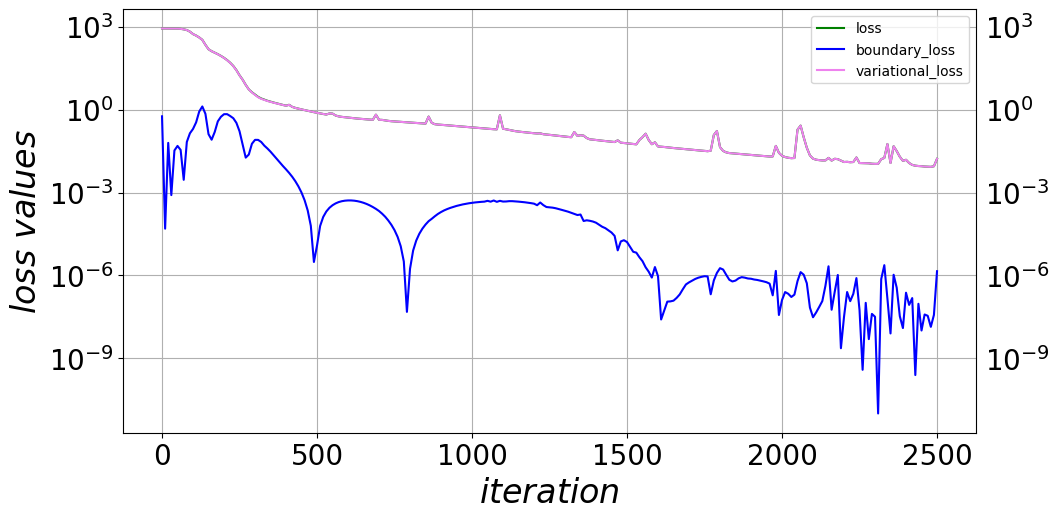

/tmp/ipykernel_17395/3869275231.py:336: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


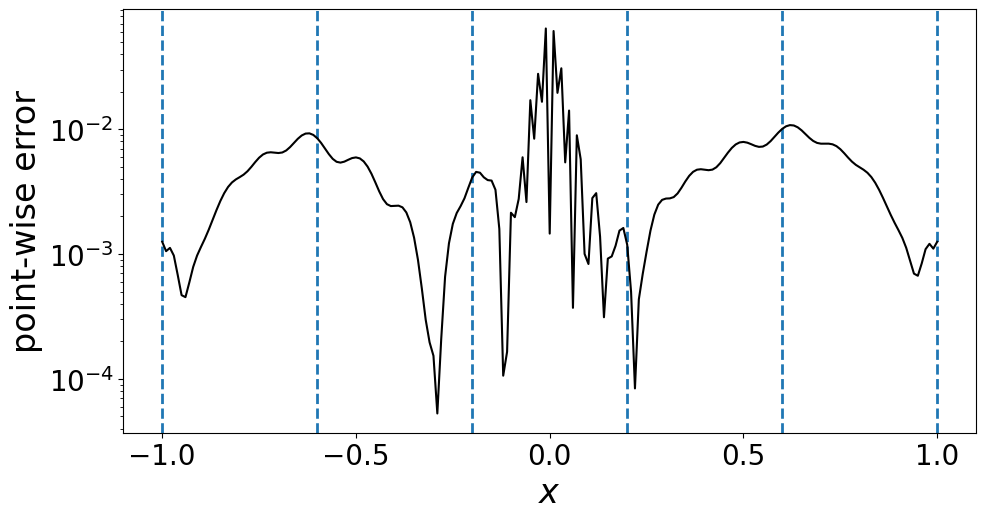

Number of elements :  10


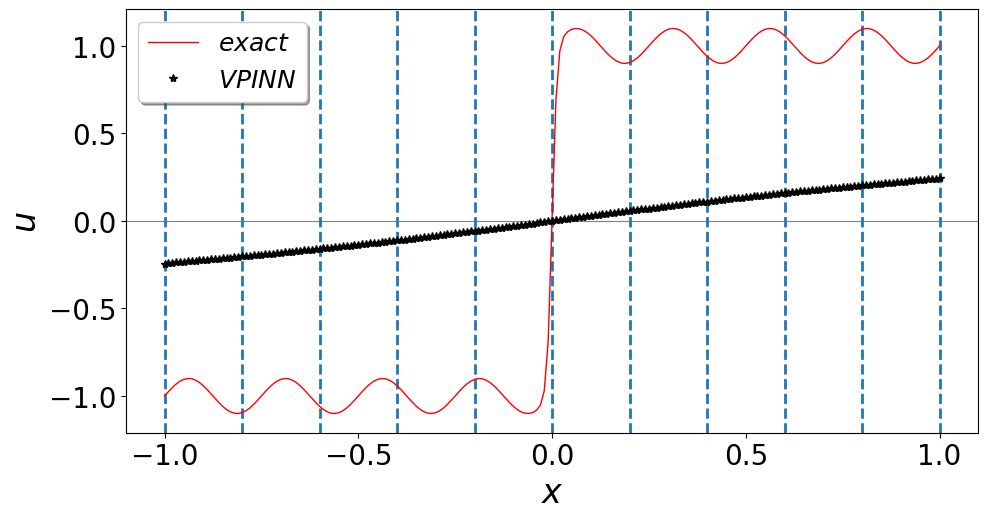

Iteration: 0 loss: 645.327615 time: 8.235863447189331
Iteration: 10 loss: 644.704395 time: 0.02014446258544922
Iteration: 20 loss: 644.472969 time: 0.018441438674926758
Iteration: 30 loss: 643.546414 time: 0.019066572189331055
Iteration: 40 loss: 640.759078 time: 0.017759084701538086
Iteration: 50 loss: 633.558951 time: 0.01920032501220703
Iteration: 60 loss: 619.235368 time: 0.02047443389892578
Iteration: 70 loss: 599.329272 time: 0.0191650390625
Iteration: 80 loss: 582.718660 time: 0.017995834350585938
Iteration: 90 loss: 537.879453 time: 0.018536806106567383
Iteration: 100 loss: 481.447837 time: 0.018962621688842773
Iteration: 110 loss: 460.563793 time: 0.019459009170532227
Iteration: 120 loss: 437.235835 time: 0.028073787689208984
Iteration: 130 loss: 409.986858 time: 0.023146629333496094
Iteration: 140 loss: 373.989998 time: 0.023367643356323242
Iteration: 150 loss: 323.563454 time: 0.019680500030517578
Iteration: 160 loss: 275.685054 time: 0.019166231155395508
Iteration: 170 loss

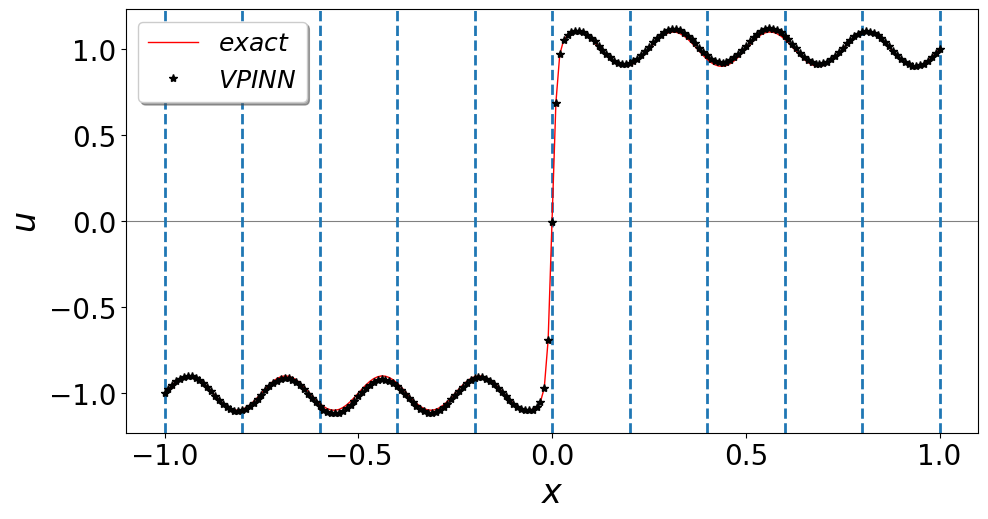

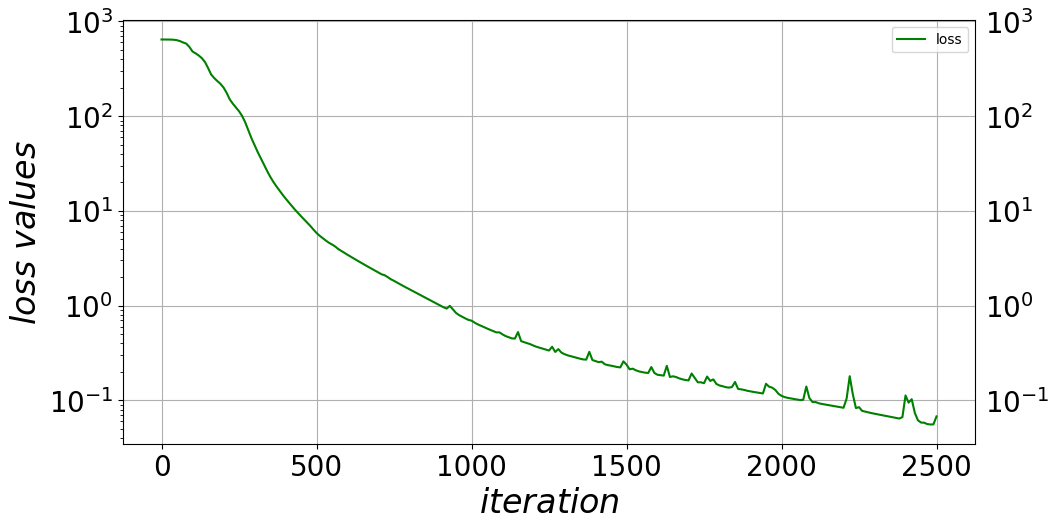

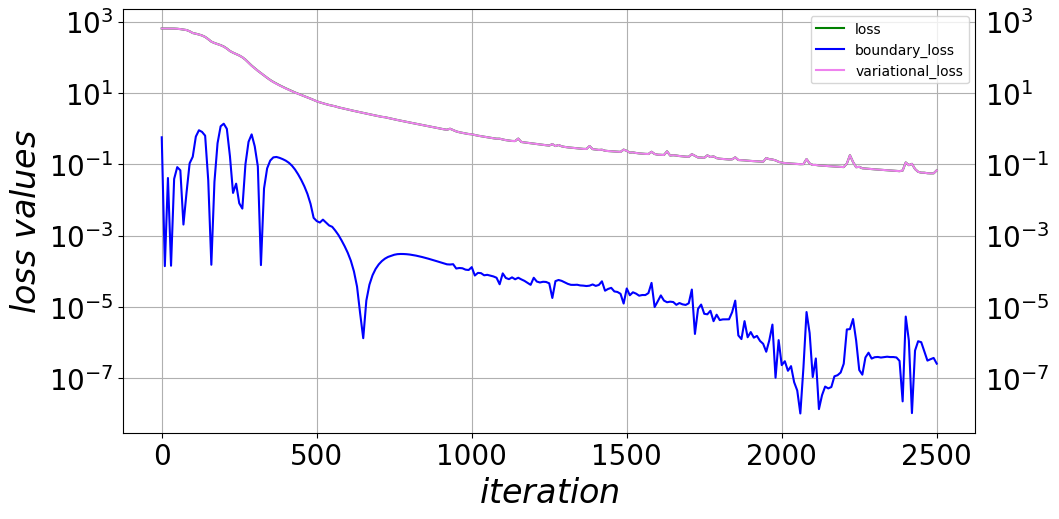

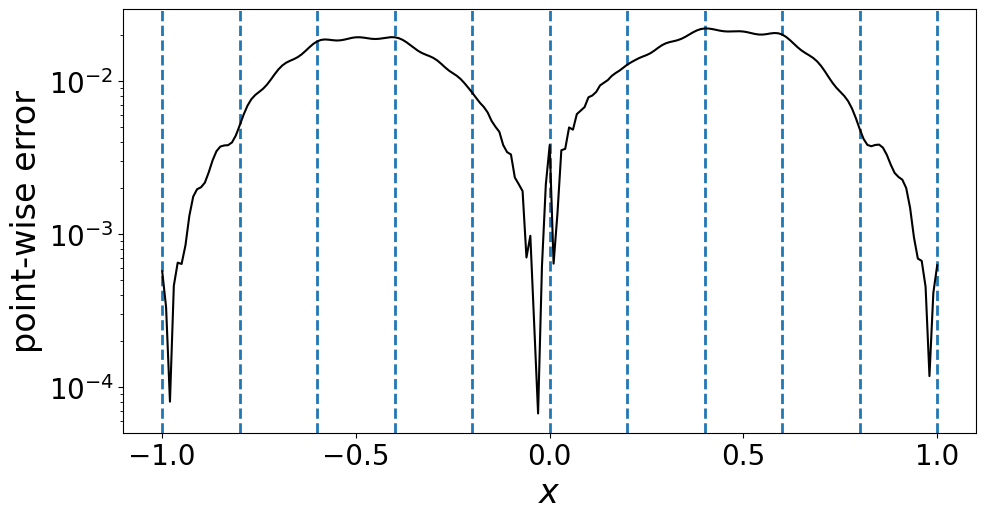

Number of elements :  20


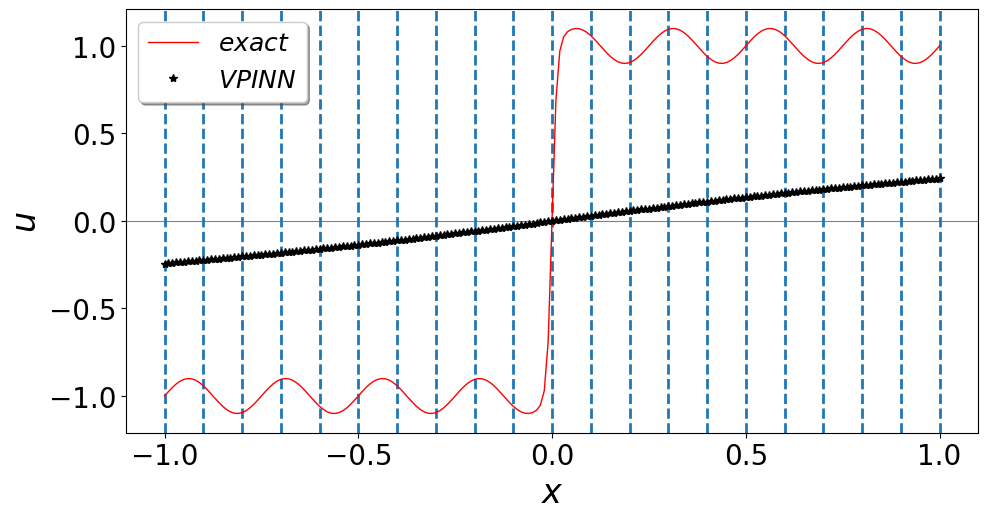

Iteration: 0 loss: 835.285095 time: 15.928496837615967
Iteration: 10 loss: 834.674632 time: 0.0299685001373291
Iteration: 20 loss: 834.668035 time: 0.030238628387451172
Iteration: 30 loss: 834.530713 time: 0.0290682315826416
Iteration: 40 loss: 834.293064 time: 0.02973651885986328
Iteration: 50 loss: 833.552145 time: 0.031200647354125977
Iteration: 60 loss: 831.271252 time: 0.030170679092407227
Iteration: 70 loss: 823.811968 time: 0.03078460693359375
Iteration: 80 loss: 800.106688 time: 0.036921024322509766
Iteration: 90 loss: 729.872005 time: 0.0464785099029541
Iteration: 100 loss: 640.464200 time: 0.03467416763305664
Iteration: 110 loss: 625.563978 time: 0.030788421630859375
Iteration: 120 loss: 592.282189 time: 0.030664682388305664
Iteration: 130 loss: 539.494214 time: 0.029874324798583984
Iteration: 140 loss: 450.000159 time: 0.03680229187011719
Iteration: 150 loss: 410.046961 time: 0.034821271896362305
Iteration: 160 loss: 388.629275 time: 0.03197121620178223
Iteration: 170 loss: 

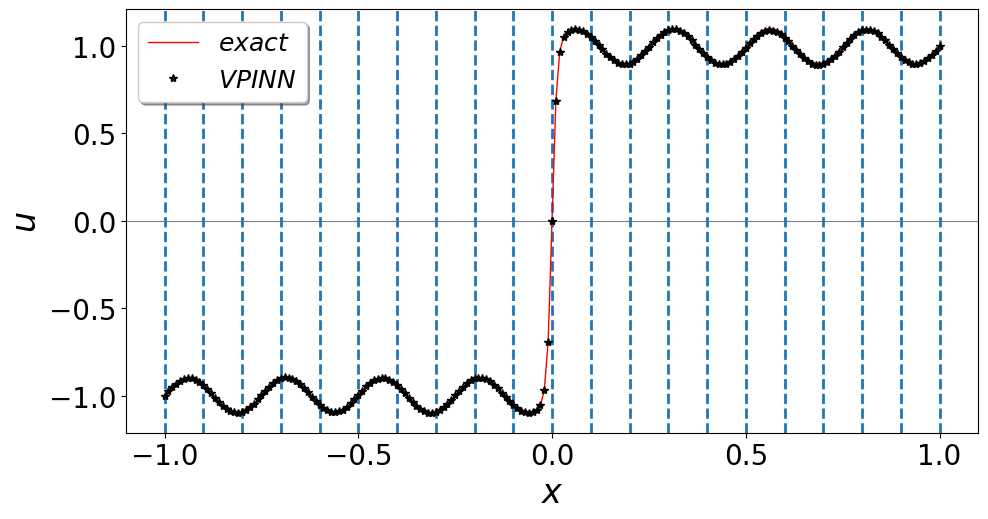

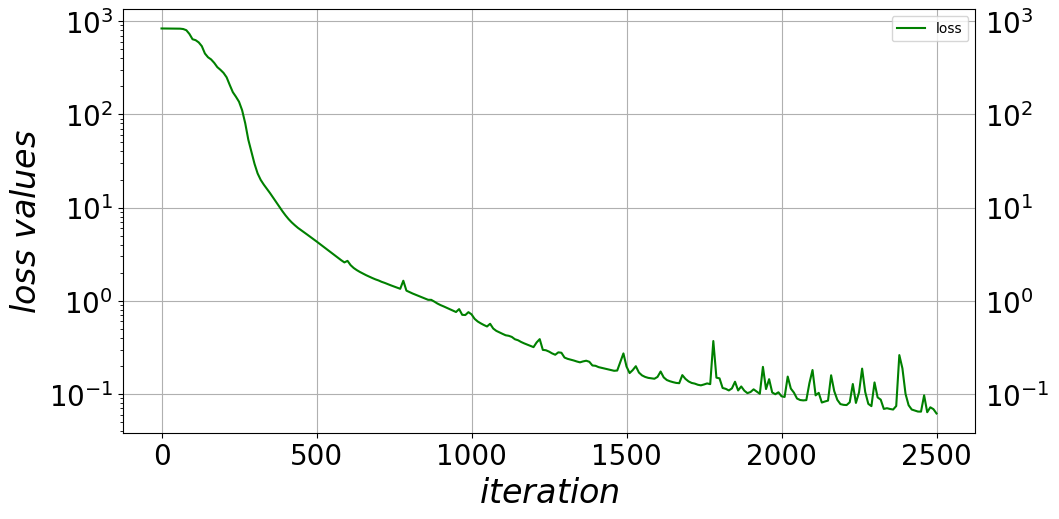

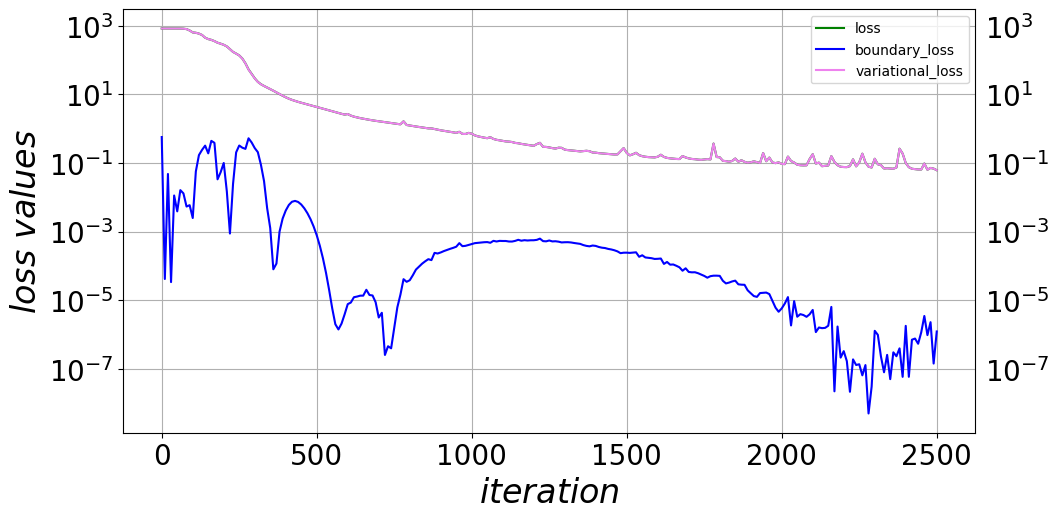

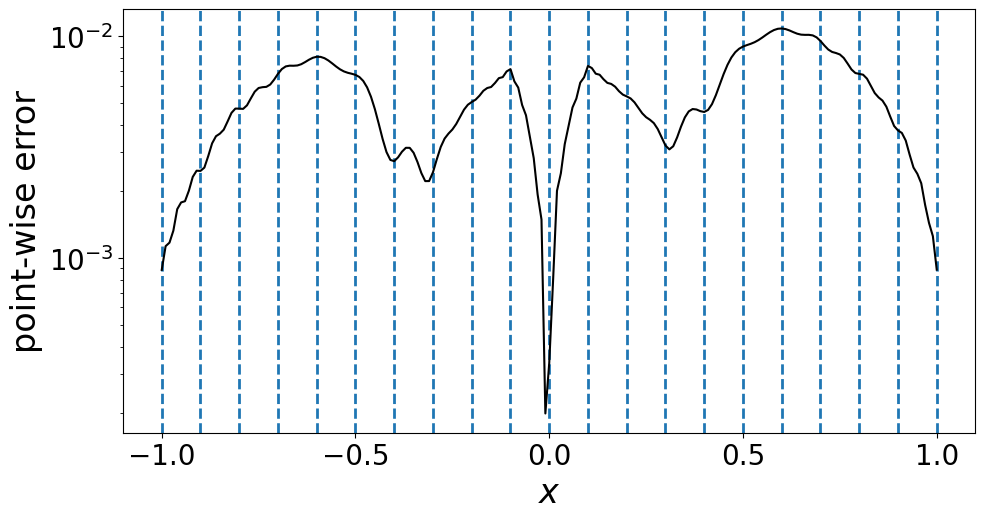

Number of elements :  40


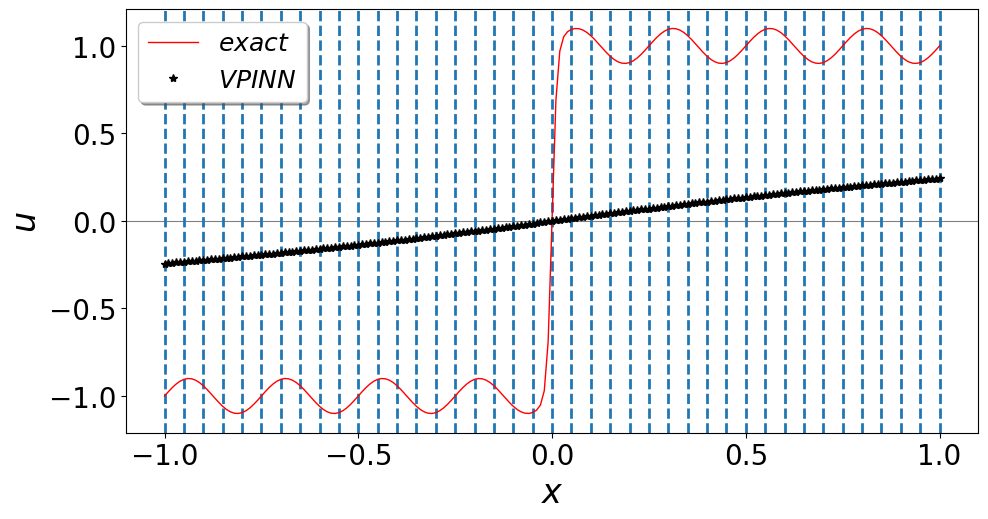

Iteration: 0 loss: 971.556234 time: 32.53149652481079
Iteration: 10 loss: 970.965976 time: 0.06050419807434082
Iteration: 20 loss: 970.993109 time: 0.06203770637512207
Iteration: 30 loss: 970.936930 time: 0.061129093170166016
Iteration: 40 loss: 970.909553 time: 0.06593179702758789
Iteration: 50 loss: 970.828786 time: 0.07037210464477539
Iteration: 60 loss: 970.630739 time: 0.06534624099731445
Iteration: 70 loss: 970.049762 time: 0.0640254020690918
Iteration: 80 loss: 968.029051 time: 0.07129502296447754
Iteration: 90 loss: 960.560980 time: 0.07970356941223145
Iteration: 100 loss: 933.208790 time: 0.06057572364807129
Iteration: 110 loss: 848.807344 time: 0.06305503845214844
Iteration: 120 loss: 679.770532 time: 0.07456660270690918
Iteration: 130 loss: 559.626128 time: 0.07268404960632324
Iteration: 140 loss: 521.690113 time: 0.06288599967956543
Iteration: 150 loss: 501.531299 time: 0.06437921524047852
Iteration: 160 loss: 477.065546 time: 0.06994152069091797
Iteration: 170 loss: 457.39

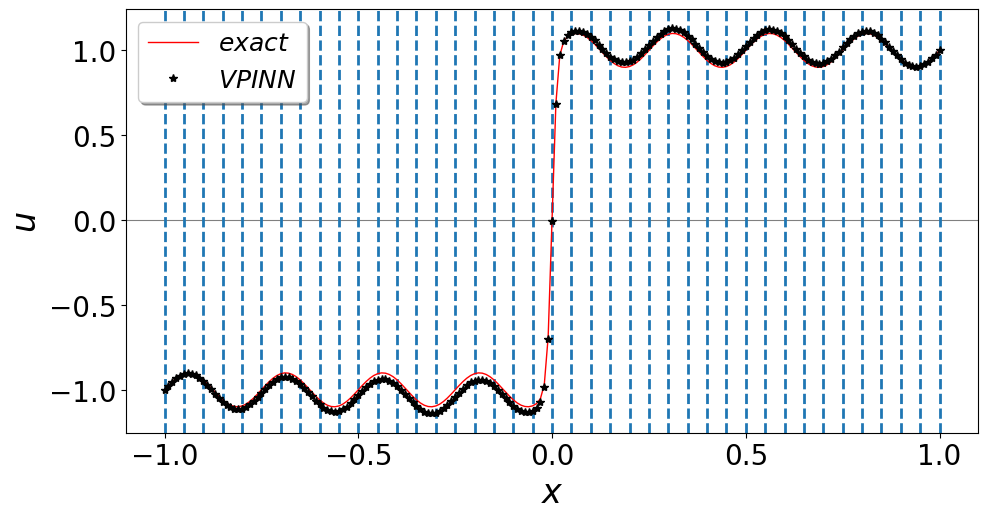

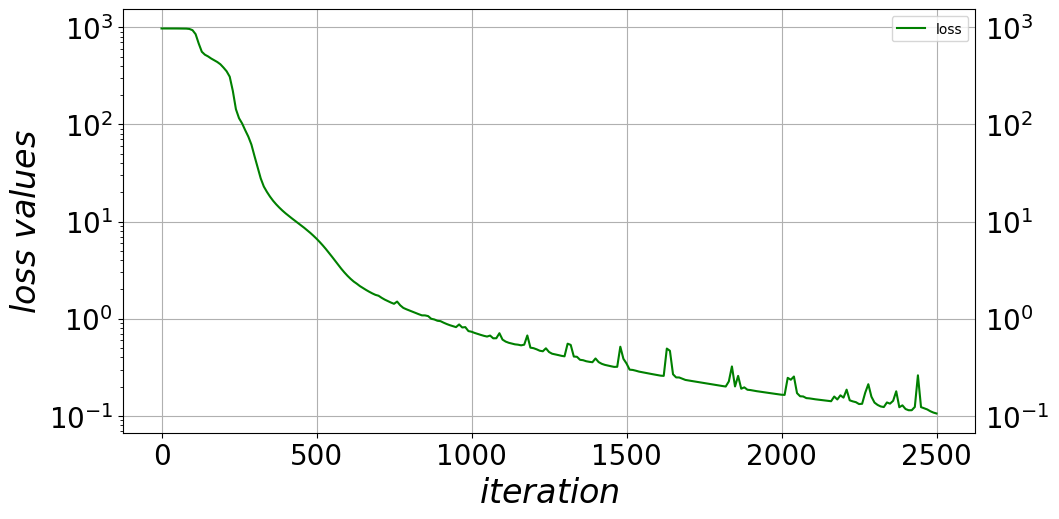

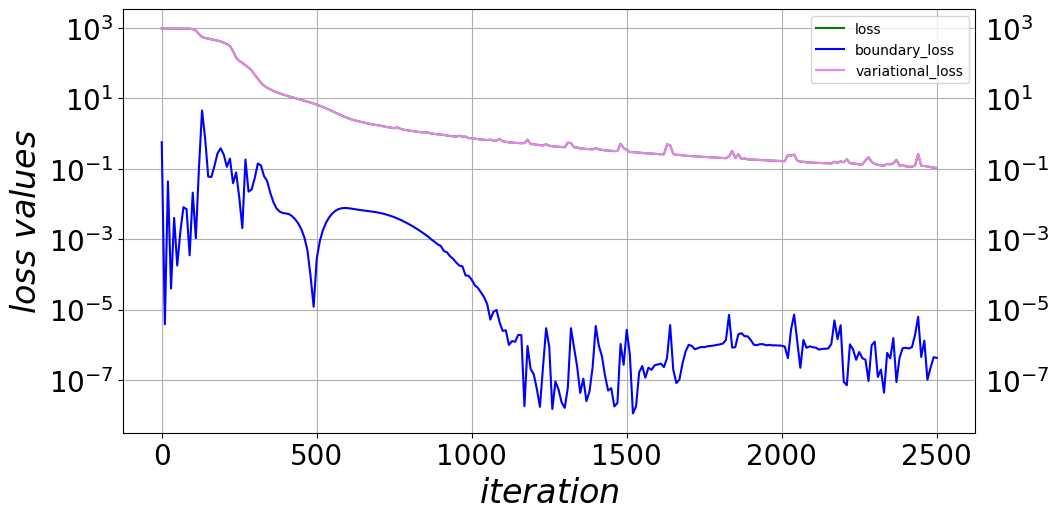

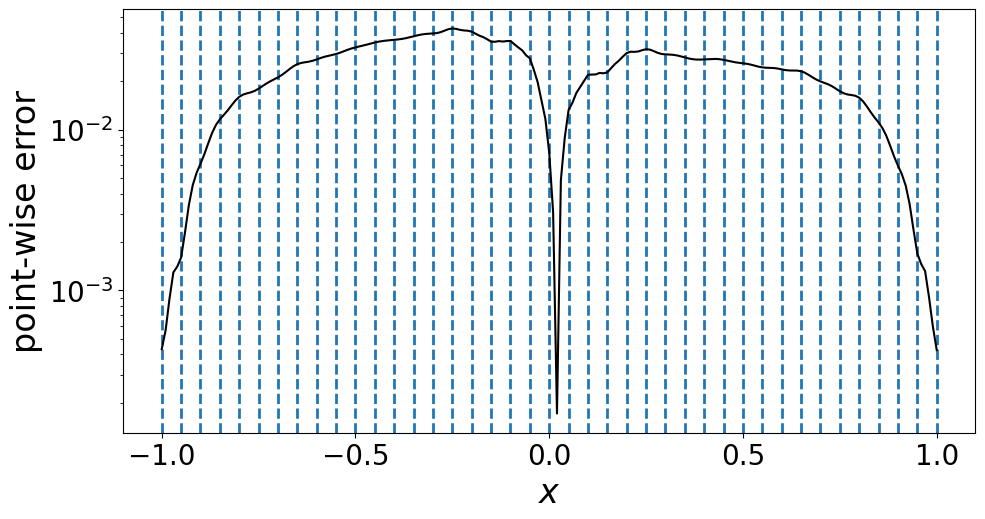

In [5]:
PLOT = 'show'

# incrasing number of elem

n=[5,10,20,40,80]

for elem in n:

    params['n_elements']=elem
    params['n_test']=elem*[N_tests]
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    model = VPINN(pb,params,42,None)
    print("Number of elements : ",elem)
    model.plot_predict(PLOT)

    loss_his = model.train(params['Opt_Niter'])

    model.plot_predict(PLOT)
    model.plot_loss_history(PLOT)    
    model.plot_pointwise_error(PLOT)


In [6]:
print(model.NN.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 20)                40        
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1321 (10.32 KB)
Trainable params: 1321 (10.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
print(params['NN_struct'][0])
input=tf.constant([[1.0],[2.0]],dtype=tf.float64)
print(input)

#the input must be a tensor of two dims(col)
#if you inherit from tf.keras model and you init like you did you can view the structure of the the net if you type:
print(model.NN(input))


1
tf.Tensor(
[[1.]
 [2.]], shape=(2, 1), dtype=float64)
tf.Tensor(
[[ 1.00042544]
 [-0.91719923]], shape=(2, 1), dtype=float64)
